# **Laboratorijska vježba 7**: Zadaci za samostalni rad

## **Predviđanje udomljavanja životinja**

U ovoj laboratorijskoj vježbi istražit ćemo skup podataka koji sadrži podatke o životinjama iz skloništa za životinje. Cilj je izgraditi i trenirati algoritam strojnog učenja koji će predvidjeti hoće li životinja iz skloništa biti udomljena ili ne. Skup podataka sadrži sljedeće značajke:

* animal_type - tip životinje
* intake_year - godina primanja u sklonište
* intake_condition - stanje životinje pri primanju u sklonište
* intake_number - broj slučajeva kada je ista životinja dovedena u sklonište
* intake_type - tip donošenja u sklonište (primjerice, zalutala životinja, dobrovoljna predaja vlasnika,...)
* sex_upon_intake - spol životinje i informacija o kastriranju pri primanju
* age_upon_intake - dob životinje pri primanju
* time_in_shelter_days - broj dana koja je životinja provela u skloništu
* sex_upon_outcome - spol životinje i informacija o kastriranju pri donošenju odluke o udomljavanju
* age_upon_outcome - dob životinje pri donošenju odluke o udomljavanju
* outcome_type - odluka o udomljavanju

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#Zadatak 1
from sklearn.preprocessing import OneHotEncoder

#Zadatak 2
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

#Zadatak 4
from sklearn.feature_selection import SequentialFeatureSelector

#Zadatak 5
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

data_folder = './Data/'

In [ ]:
data = pd.read_csv('Data/aac_intakes_outcomes.csv')
data = data[['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', 'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', 'outcome_type']]
data.head(5)

,animal_type,intake_year,intake_condition,intake_number,intake_type,sex_upon_intake,age_upon_intake_(years),time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(years),outcome_type
0,Dog,2017,Normal,1.0,Stray,Neutered Male,10.0,0.588194,Neutered Male,10.0,Return to Owner
1,Dog,2014,Normal,2.0,Public Assist,Neutered Male,7.0,1.259722,Neutered Male,7.0,Return to Owner
2,Dog,2014,Normal,3.0,Public Assist,Neutered Male,6.0,1.113889,Neutered Male,6.0,Return to Owner
3,Dog,2014,Normal,1.0,Owner Surrender,Neutered Male,10.0,4.970139,Neutered Male,10.0,Transfer
4,Dog,2013,Injured,1.0,Public Assist,Neutered Male,16.0,0.119444,Neutered Male,16.0,Return to Owner


## **Zadatak 1: Transformacija značajki**

Uredite skup podataka na način da rukujete s nedostajućim vrijednostima. Provjerite ima li takvih vrijednosti te ih uklonite ili nadomjestite prikladnim vrijednostima.



In [ ]:
print(data.isnull().sum().sum())
#43336 nedostajuće vrijednosti, skoro svi spadaju pod "outcome_subtype"

#Odabrao sam obrisati nedostajuće podatke iako ispod zakomentirano se može vidjeti na koji način bih popunio nedostajuće vrijednosti
data.dropna(inplace=True)

"""
#Nadomještanje nedostajućih vrijednosti sa najčešćim vrijednostima
data['outcome_type'].fillna(data['outcome_type'].mode()[0], inplace=True)
data['sex_upon_intake'].fillna(data['sex_upon_intake'].mode()[0], inplace = True)
data['sex_upon_outcome'].fillna(data['sex_upon_outcome'].mode()[0], inplace = True)
"""

#Provjera jesu li mi nedostajući podaci obrisani
print(data.isnull().sum().sum())

12
0


Prebacite kategoričke i ordinalne značajke u numeričke pomoću *one-hot encoding* tehnike.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def encode_categorical_features(data, columns):
    ohe = OneHotEncoder()
    for col in columns:
        encoded = ohe.fit_transform(data[[col]]).toarray()
        categories = [f"{col}_{category}" for category in ohe.categories_[0]]
        for i, category in enumerate(categories):
            data[category] = encoded[:, i]
    data.drop(columns=columns, inplace=True)
    return data

def encode_outcome_types(data):
    ohe = OneHotEncoder()
    encoded = ohe.fit_transform(data[['sex_upon_outcome']]).toarray()
    outcome_labels = [category + ' outcome' for category in ohe.categories_[0]]
    for i, label in enumerate(outcome_labels):
        data[label] = encoded[:, i]
    data.drop('sex_upon_outcome', axis=1, inplace=True)
    return data

def replace_outcome_types(data):
    outcome_types = np.unique(data['outcome_type'].to_numpy())
    data['outcome_type'] = np.where(data['outcome_type'] == outcome_types[0], 1, 0)
    return data

# Example usage
categorical_cols = ['animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake']
data = encode_categorical_features(data, categorical_cols)
data = encode_outcome_types(data)
data = replace_outcome_types(data)

In [ ]:
# Ispis jedinstvenih vrijednosti značajke outcome_types
outcome_types = np.unique(data['outcome_type'].to_numpy())
print(outcome_types)

# Ispis rezultat prebacivanja kategoričkih i ordinalnih značajki u numeričke koristeći one hot encoding
data

[0 1]


,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),outcome_type,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,Intact Female outcome,Intact Male outcome,Neutered Male outcome,Spayed Female outcome,Unknown outcome
0,2017,1.0,10.000000,0.588194,10.000000,0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2014,2.0,7.000000,1.259722,7.000000,0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2014,3.0,6.000000,1.113889,6.000000,0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2014,1.0,10.000000,4.970139,10.000000,0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2013,1.0,16.000000,0.119444,16.000000,0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79667,2018,1.0,0.038356,0.077083,0.038356,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
79668,2018,1.0,2.000000,0.053472,2.000000,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
79669,2018,1.0,1.000000,0.047917,1.000000,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
79670,2018,1.0,0.410959,1.762500,0.821918,0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Normalizirajte vrijednosti svih značajki u interval $[0,1]$. 

In [ ]:
scaler = MinMaxScaler()

#Odabir svih stupaca osim stupaca koji nisu numerički u ovom slučaju object type stupce
numeric_columns = data.select_dtypes(include=[int, float]).columns

# Normalizacija Min_max skaliranja na numeričkim stupcima
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

#Provjera uspješnosti
data.head(5)

,intake_year,intake_number,age_upon_intake_(years),time_in_shelter_days,age_upon_outcome_(years),outcome_type,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,...,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown,Intact Female outcome,Intact Male outcome,Neutered Male outcome,Spayed Female outcome,Unknown outcome
0,0.8,0.000000,0.40,0.000366,0.40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.2,0.083333,0.28,0.000784,0.28,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.2,0.166667,0.24,0.000693,0.24,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.2,0.000000,0.40,0.003094,0.40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.000000,0.64,0.000074,0.64,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## **Zadatak 2: Odabir modela**

Za uređeni skup podataka provedite odabir modela. Prvo podijelite skup podataka na podskupove za treniranje i testiranje u omjeru 80:20. Zatim definirajte mrežu hiperparametara za četiri klasifikatora: DT, SVM, $k$-NN i logističku regresiju.

In [ ]:
X = data.loc[:, data.columns != 'outcome_type'].copy()
y = data['outcome_type'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

DT = tree.DecisionTreeClassifier()
tree_parameters = {'max_depth': [5,10,15]}
clf_tree = GridSearchCV(DT, tree_parameters, scoring='accuracy')
clf_tree.fit(X_train, y_train)


KNN = KNeighborsClassifier()
KNN_parameters = {'n_neighbors': [5,6,7,8]}
clf_KNN = GridSearchCV(KNN, KNN_parameters, scoring='accuracy')
clf_KNN.fit(X_train, y_train)


LogReg = LogisticRegression(max_iter=1000)
LogReg_parameters = {'C': [0.5,1,2,5,10,20]}
clf_LogReg = GridSearchCV(LogReg, LogReg_parameters, scoring='accuracy')
clf_LogReg.fit(X_train, y_train)
"""
SVC = SVC()
SVC_parameters = {'kernel': ('linear', 'rbf'), 'C': [1,5,10,50,100]}
clf_SVC = GridSearchCV(SVC, SVC_parameters, scoring='accuracy')
clf_SVC.fit(X_train, y_train)
"""

"\nSVC = SVC()\nSVC_parameters = {'kernel': ('linear', 'rbf'), 'C': [1,5,10,50,100]}\nclf_SVC = GridSearchCV(SVC, SVC_parameters, scoring='accuracy')\nclf_SVC.fit(X_train, y_train)\n"

Na podskupu za treniranje isprobajte sve kombinacije hiperparametara te usporedite najbolje kombinacije za svaki klasifikator na podskupu za testiranje. Odaberite prikladnu mjeru za usporedbu performansi. Možete koristiti klasu GridSearchCV te podijeliti podskup za trening postupkom unakrsne provjere $5$ preklopa. 

In [ ]:
y_pred = clf_tree.predict(X_test)
print("Decision Tree: ", accuracy_score(y_test, y_pred))

y_pred = clf_KNN.predict(X_test)
print("KNN: ", accuracy_score(y_test, y_pred))

y_pred = clf_LogReg.predict(X_test)
print("Logistic Regression: ", accuracy_score(y_test, y_pred))
"""
y_pred = clf_SVC.predict(X_test)
print("SVC: ", accuracy_score(y_test, y_pred))
"""

Decision Tree:  0.8401430992280173
KNN:  0.8224439841837695
Logistic Regression:  0.8173601958199962


'\ny_pred = clf_SVC.predict(X_test)\nprint("SVC: ", accuracy_score(y_test, y_pred))\n'

Prokomentirajte dobivene rezultate. Koji klasifikator ima najbolje performanse?

In [ ]:
"""
Klasifikator Stablo odlučivanja ima najbolje performanse od tri testirana klasifikatora, s točnošću od 0.8401430992280173. 
Klasifikator Stablo odlučivanja ima najveći postotak točnih predviđanja na testnom skupu u usporedbi s KNN-om i Logističkom regresijom.

--> Točnost samostalno možda nije jedini faktor koji treba uzeti u obzir priliko procjene performansi klasifikatora <--
"""

## **Zadatak 3: Odabir značajki - filtri**

Podijelite uređeni skup podataka na podskupove za treniranje i testiranje u omjeru 80:20 (koristite isto stanje nasumičnosti kao i u Zadatku 2).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

Pomoću proizvoljnog filtra provedite odabir značajki za promatrani skup podataka. Rangirajte sve značajki na temelju vrijednosti mjere unutar filtra te iscrtajte stupčasti dijagram tih vrijednosti. 

Odabrane značajke: 
['animal_type_Dog' 'animal_type_Other' 'intake_condition_Normal'
 'intake_condition_Sick' 'intake_type_Owner Surrender'
 'intake_type_Public Assist' 'intake_type_Wildlife'
 'sex_upon_intake_Unknown' 'Intact Female outcome' 'Intact Male outcome'
 'Neutered Male outcome' 'Spayed Female outcome' 'Unknown outcome']
Odabrane značajke: 
['age_upon_intake_(years)' 'time_in_shelter_days'
 'age_upon_outcome_(years)']
Decision Tree:  0.8388250800225946


<BarContainer object of 5 artists>

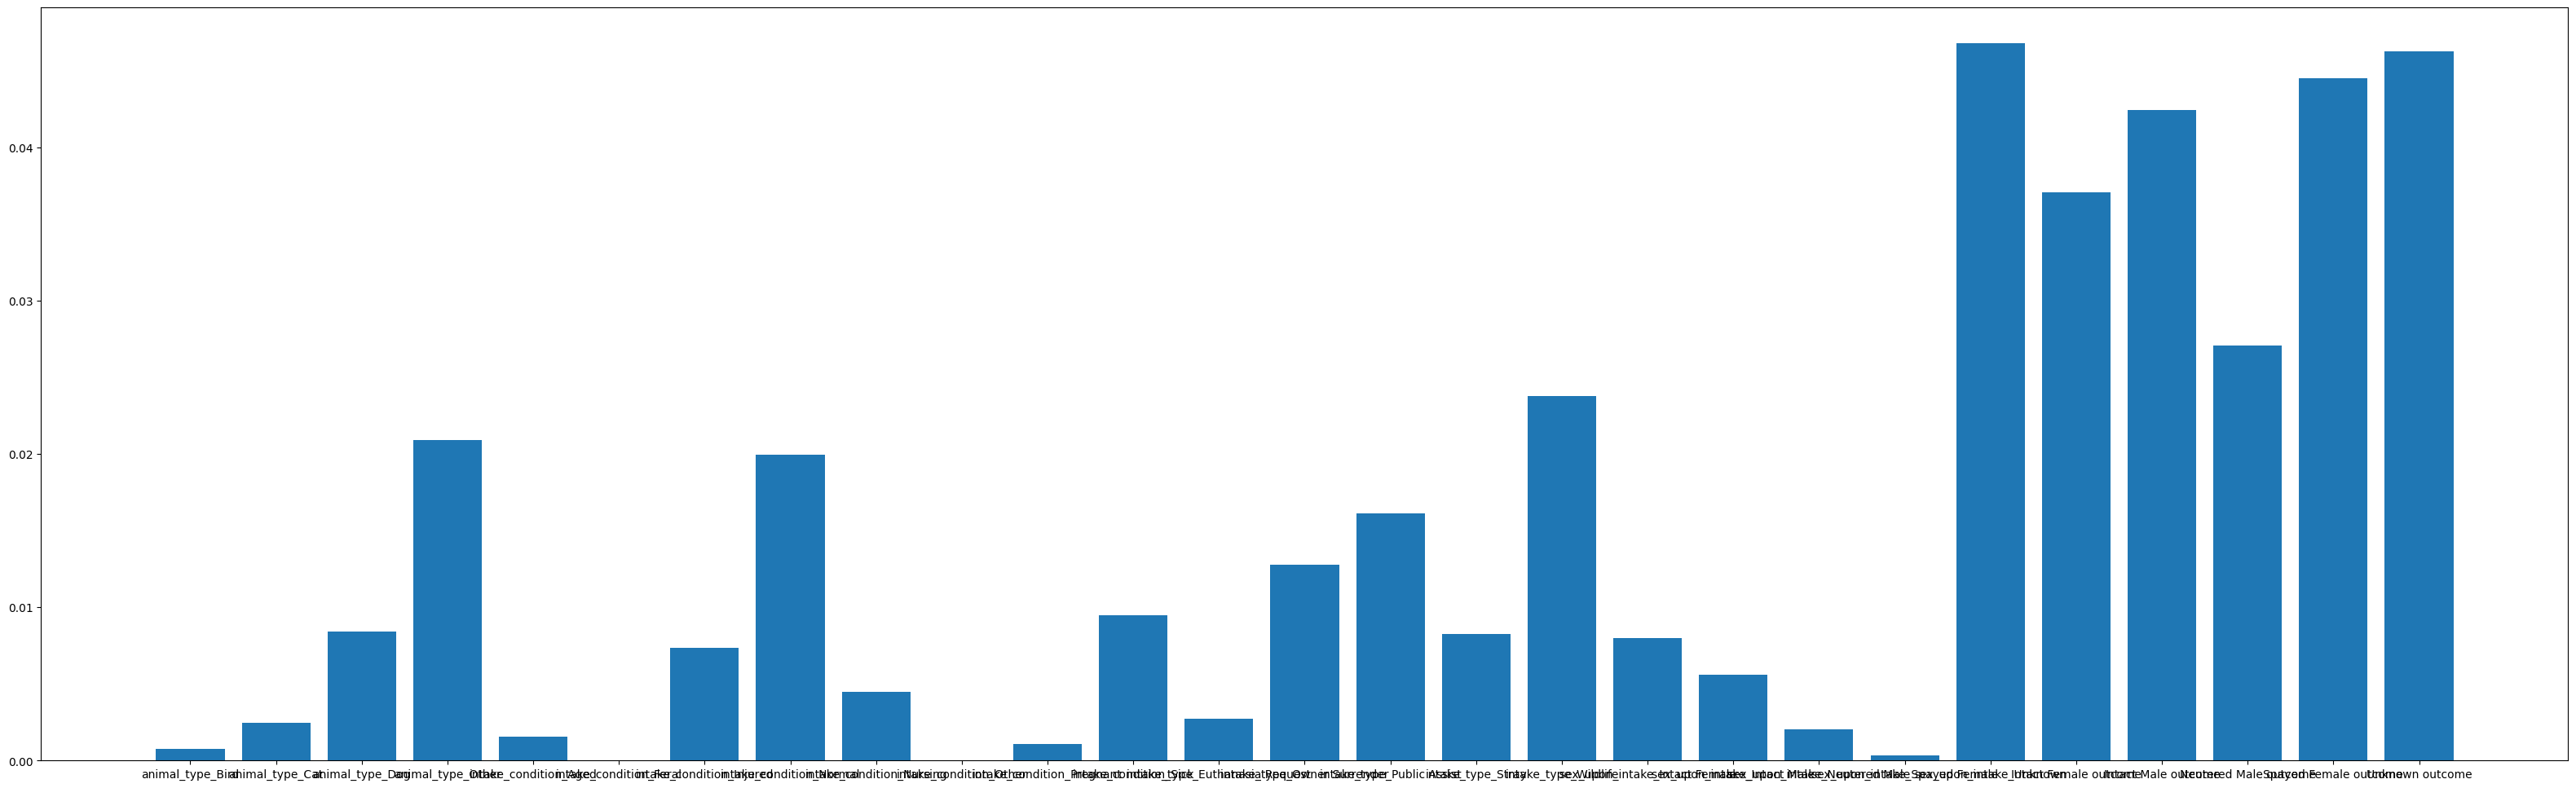

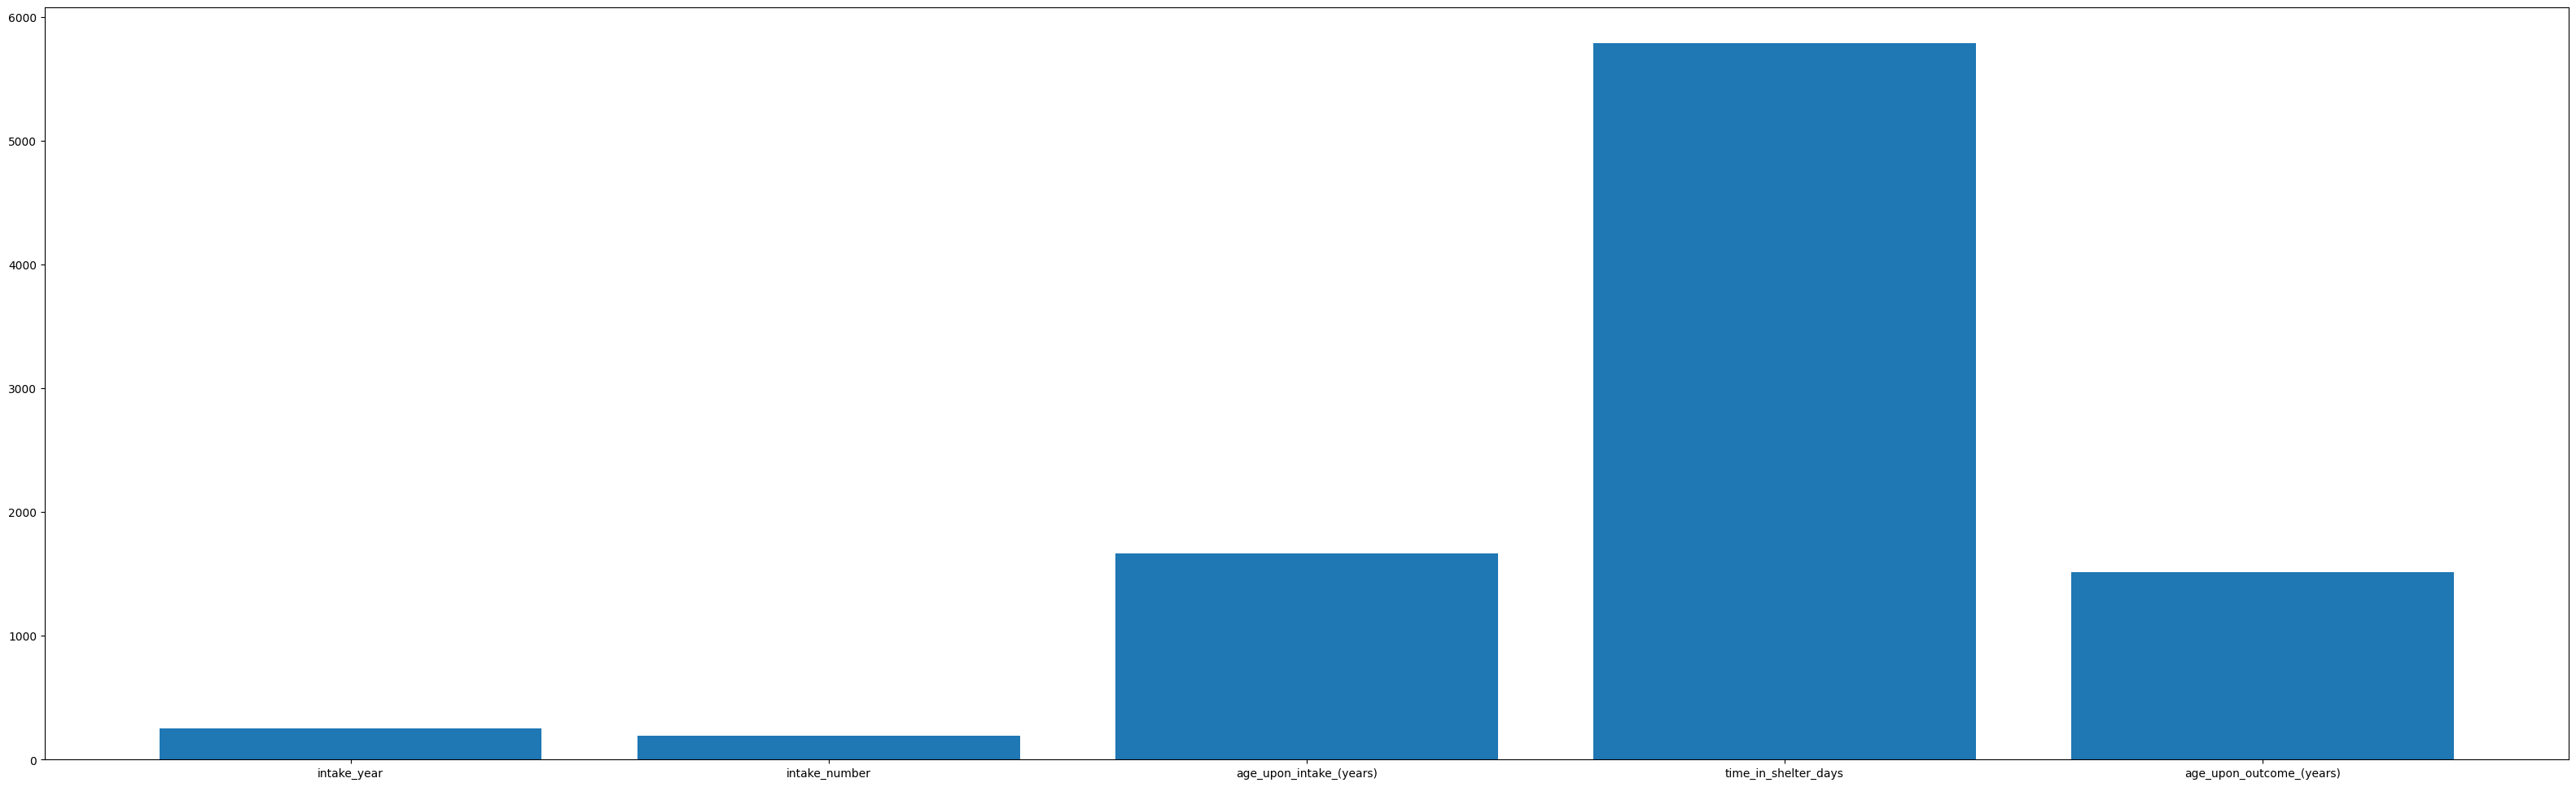

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

skb_categorical = SelectKBest(mutual_info_classif, k=13)
X_categorical = X.iloc[:, 5:]
X_new_categorical = skb_categorical.fit_transform(X_categorical,y)
print("Odabrane značajke: ")
print(skb_categorical.get_feature_names_out())

skb_numerical = SelectKBest(f_classif, k=3)
X_numerical = X.iloc[:, 0:5]
X_new_numerical = skb_numerical.fit_transform(X_numerical,y)
print("Odabrane značajke: ")
print(skb_numerical.get_feature_names_out())

X_important = np.concatenate((skb_categorical.get_feature_names_out(), skb_numerical.get_feature_names_out()))
X_train_important = X_train[X_important].copy()
X_test_important = X_test[X_important].copy()

clf_tree.fit(X_train_important, y_train)
y_pred = clf_tree.predict(X_test_important)
print("Decision Tree: ", accuracy_score(y_test, y_pred))

plt.figure(figsize=(40,12))
plt.bar(X_categorical.columns, skb_categorical.scores_)

plt.figure(figsize=(40,12))
plt.bar(X_numerical.columns, skb_numerical.scores_)

Odaberite $K$ najbolje rangiranih značajki te trenirajte klasifikatore na podskupu za treniranje koristeći odabrane značajke. Možete koristiti najbolje klasifikatore iz Zadatka 2. Samostalno odaberite prikladnu vrijednost za $K$. Usporedite performanse ovih klasifikatora na podskupu za testiranje prije i nakon odabira značajki.  

## **Zadatak 4: Odabir značajki - omotači**


Podijelite uređeni skup podataka na podskupove za treniranje i testiranje u omjeru 80:20 (koristite isto stanje nasumičnosti kao i u Zadatku 2). Zatim dodatno podijelite podskup za treniranje na podskupove za treniranje i vrednovanje u omjeru 65:35. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)
X_train_v, X_validation, y_train_v, y_validation = train_test_split(X_train, y_train, test_size=0.35, random_state=2)

Pomoću omotača SFS provedite odabir značajki za promatrani skup podataka. Isprobajte nekoliko različitih vrijednosti za konačan broj značajki, vodeći se performansama klasifikatora. Možete koristiti najbolji klasifikator iz Zadatka 2 za vrednovanje podskupova značajki. Napomena: klasifikator trenirajte na podskupu za trening, a podskupove značajki koje stvara SFS vrednujte na podskupu za vrednovanje.

In [ ]:
clf_tree.fit(X_train_v, y_train_v)
print("Before FS: ", accuracy_score(y_validation, clf_tree.predict(X_validation)))

sfs = SequentialFeatureSelector(tree.DecisionTreeClassifier(max_depth=clf_tree.best_params_['max_depth']), n_features_to_select=15, direction='forward').fit(X_train,y_train)
selected_features = X_train_v.columns[sfs.support_]

clf_tree.fit(X_train_v[selected_features], y_train_v)
print("After FS: ", accuracy_score(y_validation, clf_tree.predict(X_validation[selected_features])))

Before FS:  0.8473436449226631
After FS:  0.8440260031383098


In [ ]:
"""
Before FS: 0.8473436449226631
After FS: 0.8440260031383098

Točnost klasifikatora se malo smanjila.
Ovo može ukazivati na to da je selekcija značajki možda uklonila neke informacije koje su bile korisne za klasifikaciju.
"""

Najbolje klasifikatore iz Zadatka 2 trenirajte na objedinjenom podskupu za treniranje i vrednovanje, koristeći odabrane značajke iz ovog zadatka. Usporedite performanse ovih klasifikatora na podskupu za testiranje prije i nakon odabira značajki.

In [ ]:
clf_tree.fit(X_train[selected_features], y_train)
print("Nakon omotača: ", accuracy_score(y_test, clf_tree.predict(X_test[selected_features])))

Nakon omotača:  0.842277035084416


## **Zadatak 5: Preuzorkovanje**

Podijelite uređeni skup podataka na podskupove za treniranje i testiranje u omjeru 80:20 (koristite isto stanje nasumičnosti kao i u Zadatku 2).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

Pomoću metode nasumičnog preuzorkovanja provedite preuzorkovanje podskupa za treniranje.

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_new_train, y_new_train = oversample.fit_resample(X_train, y_train)

clf_tree.fit(X_new_train, y_new_train)
y_pred = clf_tree.predict(X_test)
print("Decision Tree: ", accuracy_score(y_test, y_pred))

Decision Tree:  0.8352475993221615


In [ ]:
"""
Decision Tree: 0.8352475993221615
"""

Najbolje klasifikatore iz Zadatka 2 trenirajte na preuzorkovanom podskupu za treniranje. Usporedite performanse ovih klasifikatora na podskupu za testiranje prije i nakon preuzorkovanja. 

In [ ]:
oversampler = RandomOverSampler()
X_new, y_new = oversampler.fit_resample(X_train, y_train)

dt_clf_pre = DecisionTreeClassifier(criterion='log_loss', max_depth=70, splitter='best')
dt_clf_pre.fit(X_train, y_train)
y_pred_pre = dt_clf_pre.predict(X_test)
accuracy_pre = accuracy_score(y_test, y_pred_pre)
print("Prije preuzorkovanja:", accuracy_pre)

dt_clf_post = DecisionTreeClassifier(criterion='log_loss', max_depth=70, splitter='best')
dt_clf_post.fit(X_new, y_new)
y_pred_post = dt_clf_post.predict(X_test)
accuracy_post = accuracy_score(y_test, y_pred_post)
print("Nakon preuzorkovanja:", accuracy_post)

Prije preuzorkovanja: 0.8097658946839892
Nakon preuzorkovanja: 0.8132178497458106


In [ ]:
"""
Preuzorkovanje je doprinijelo poboljšanju sposobnosti klasifikatora da generalizira na nepoznate primjere, s obzirom na povećanje točnosti na nebalansiranom podskupu za testiranje.
"""